# Fujitsu IP Analytics
## Project: Backorders prediction

This project analyses the data from a distributor.

## Getting Started
Loading the dataset

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from time import time
import scipy
import matplotlib.patches as mpatches
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.decomposition import PCA,NMF
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
import helper as hp
# Pretty display for notebooks
%matplotlib inline
print "Libraries imported successfully"

Libraries imported successfully


In [2]:
# Load the backorders training dataset
try:
    data = pd.read_csv('backorderTrain.csv',header =0)
    print "backorders dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

backorders dataset has 1693050 samples with 23 features each.


## Data Exploration
the author of the database labelled with 1 no exoplanet system and 2 exoplanet system

In [3]:
#create label array
for col in ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk','stop_auto_buy', 'rev_stop','went_on_backorder']:
        data[col] = (data[col] == 'Yes').astype(int)
labels = data.went_on_backorder

sku                       0
national_inv              0
lead_time            101334
in_transit_qty            0
forecast_3_month          0
forecast_6_month          0
forecast_9_month          0
sales_1_month             0
sales_3_month             0
sales_6_month             0
sales_9_month             0
min_bank                  0
potential_issue           0
pieces_past_due           0
perf_6_month_avg          0
perf_12_month_avg         0
local_bo_qty              0
deck_risk                 0
oe_constraint             0
ppap_risk                 0
stop_auto_buy             0
rev_stop                  0
went_on_backorder         0
dtype: int64

1693050L

1693050

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000000150ABC50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000C03C278>], dtype=object)

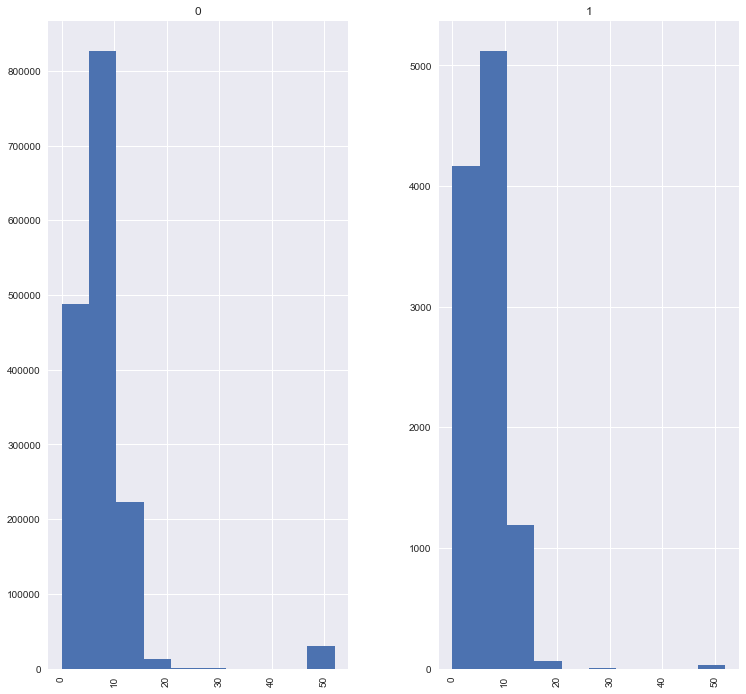

In [4]:
# Display a description of the dataset
#display(data.describe())
display(data.isnull().sum())
display(data.sku.unique().shape[0])
display(data.sku.count())

pd.DataFrame.hist(data, column='lead_time', by = 'went_on_backorder',figsize = (12,12))

In [5]:
#numerical columns
num_col = ['national_inv','in_transit_qty','forecast_3_month','forecast_6_month',
           'forecast_9_month','sales_1_month','sales_3_month','sales_6_month','sales_9_month','min_bank',
          'pieces_past_due','perf_6_month_avg','perf_12_month_avg','local_bo_qty']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001FDDCA90>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000020F7E9B0>], dtype=object)

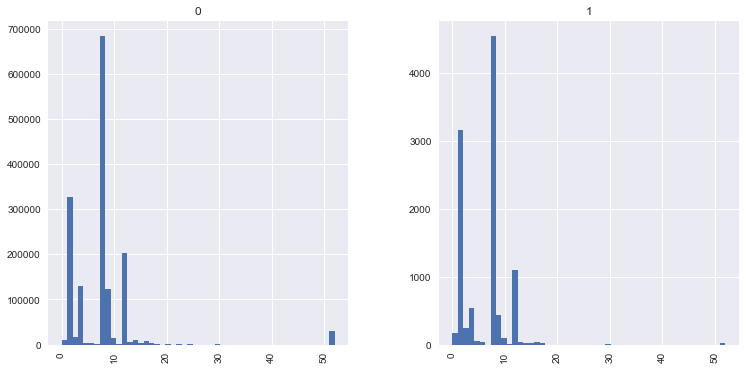

In [6]:
display(pd.DataFrame.hist(data, column='lead_time', by = 'went_on_backorder',figsize = (12,6), sharex = True,
                         bins =50))

In [7]:
data.drop(['lead_time','sku','went_on_backorder'],axis=1, inplace =True)

In [8]:
#scaling the features
#Normalise the data using the standard scaler
# 0 mean and 1 std
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(-5000, 5000), copy=True)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(copy=True, with_mean=True, with_std=True)

scaler  = Pipeline([('min_max',mms),('std',sc)])

std_data = pd.DataFrame(scaler.fit_transform(data), columns = data.keys())

In [26]:
#save standardised data
pickle.dump((std_data,labels), open('std_data.p', 'wb'))

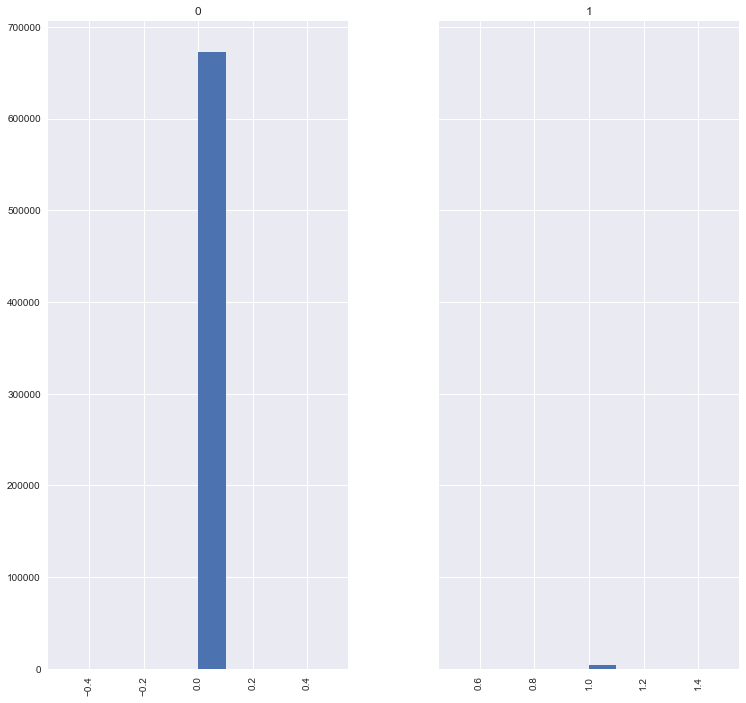

In [11]:
#save sample data
samples = std_data
samples['label'] = labels
samples  = samples.sample(frac=0.4)
pd.DataFrame.hist(samples, column='label', by = 'label',figsize = (12,12), sharey = True)
samples_labels = samples.label
samples.drop('label',axis =1, inplace = True)
pickle.dump((samples,samples_labels), open('samples.p', 'wb'))

In [51]:
kb = SelectKBest(k=10)
feat_data = kb.fit_transform(std_data,labels)
indices =  kb.get_support(indices=True) -1
print indices
feat_data = pd.DataFrame(feat_data, columns = data.columns[indices])
display(feat_data.info())

[ 0  9 10 11 12 13 14 16 18 19]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1693050 entries, 0 to 1693049
Data columns (total 10 columns):
national_inv         float64
min_bank             float64
potential_issue      float64
pieces_past_due      float64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty         float64
oe_constraint        float64
stop_auto_buy        float64
rev_stop             float64
dtypes: float64(10)
memory usage: 129.2 MB


None

In [ ]:
# Create a DataFrame of the chosen samples
plt.figure(figsize =(12,12))
samples = feat_data
samples['label'] = labels
display(pd.tools.plotting.radviz(samples, 'label'))

In [ ]:
plt.figure(figsize =(12,12))
samples = std_data
samples['label'] = labels
samples_labels = samples.label
pd.tools.plotting.radviz(samples.sample(50000), 'label')

In [15]:
def vs_frontiers(good_data,good_lables):
    from scipy import stats
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.font_manager
    from sklearn import svm
    from sklearn.pipeline import Pipeline
    pca = PCA(n_components=2, random_state = 42)
    X_train = pca.fit_transform(good_data[good_lables == 0])
    X_test = pca.transform(good_data[good_lables == 0].sample(10634))
    X_outliers = pca.transform(good_data[good_lables == 1])
    outliers_fraction = 0.1
    
    # fit the model
    clf = IsolationForest(n_jobs = -1,random_state =42).fit(X_train)
    #clf = svm.OneClassSVM().fit(X_train)
    xmin, ymin = np.amin(X_train, axis=0)
    print  xmin, ymin
    xmax, ymax = np.amax(X_train, axis=0)
    print  xmax, ymax
    xmin, ymin ,xmax, ymax = xmin -20, ymin -20 ,xmax + 20, ymax +20
    
    xx, yy = np.meshgrid(np.linspace(xmin,xmax, 600), np.linspace(ymin,ymax, 600))
    
    #predict
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    y_pred_outliers =clf.predict(X_outliers)
    n_error_train = y_pred_train[y_pred_train == -1].size
    n_error_test = y_pred_test[y_pred_test == -1].size
    n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

    # plot the line, the points, and the nearest vectors to the plane
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(12,12))
    plt.title("Novelty Detection")
    scores_pred = clf.decision_function(X_train)
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    #threshold = -0.18
    print Z.min()
    print threshold
    print Z.max()
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.PuBu)
    a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='darkred')
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='palevioletred')
    s = 30
    b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white', s=s)
    b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
    c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
    plt.axis('tight')
    plt.xlim((xmin,xmax))
    plt.ylim((ymin,ymax))
    plt.legend([a.collections[0], b1, b2, c],
               ["learned frontier", "training observations",
                "new regular observations", "new abnormal observations"],
               loc="upper left",
               prop=matplotlib.font_manager.FontProperties(size=11))
    plt.xlabel(
        "error train: %d/168214 ; errors novel regular: %d/10634 ; "
        "errors novel abnormal: %d/10634"
        % (n_error_train, n_error_test, n_error_outliers))
    plt.show()

-5.16407437822 -0.159669114858
8.88822360548 354.413896764
-0.281569462723
-0.0497324345121
0.0750245412119


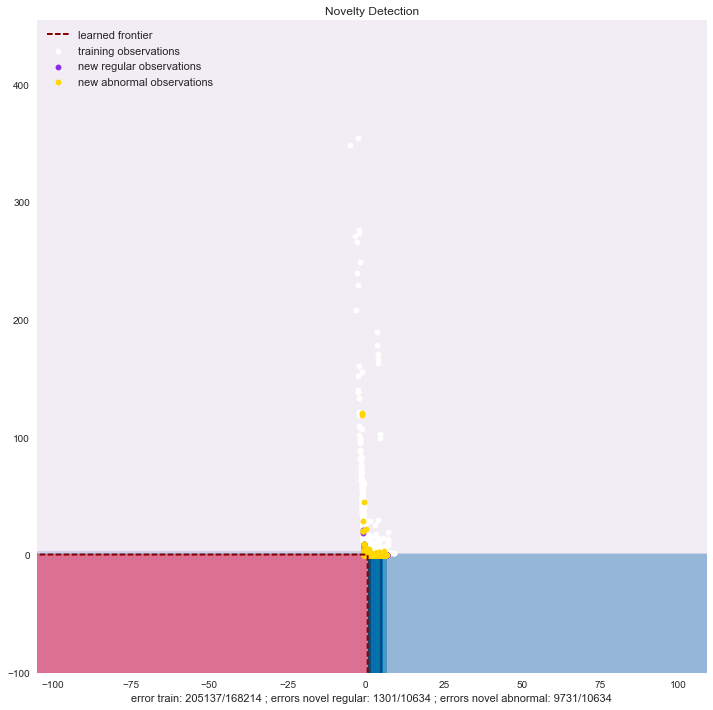

In [55]:
vs_frontiers(feat_data,labels)

-0.142164475999 -9.07111619725
596.1370803 14.789745094
-0.300573489517
-0.0372919735622
0.143381889634


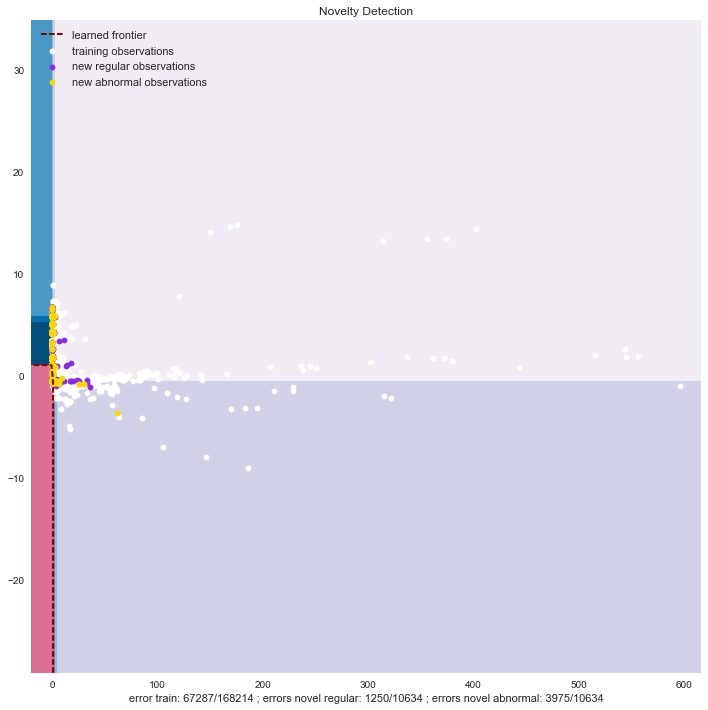

In [16]:
#vs_frontiers(std_data,labels)
vs_frontiers(samples,samples_labels)

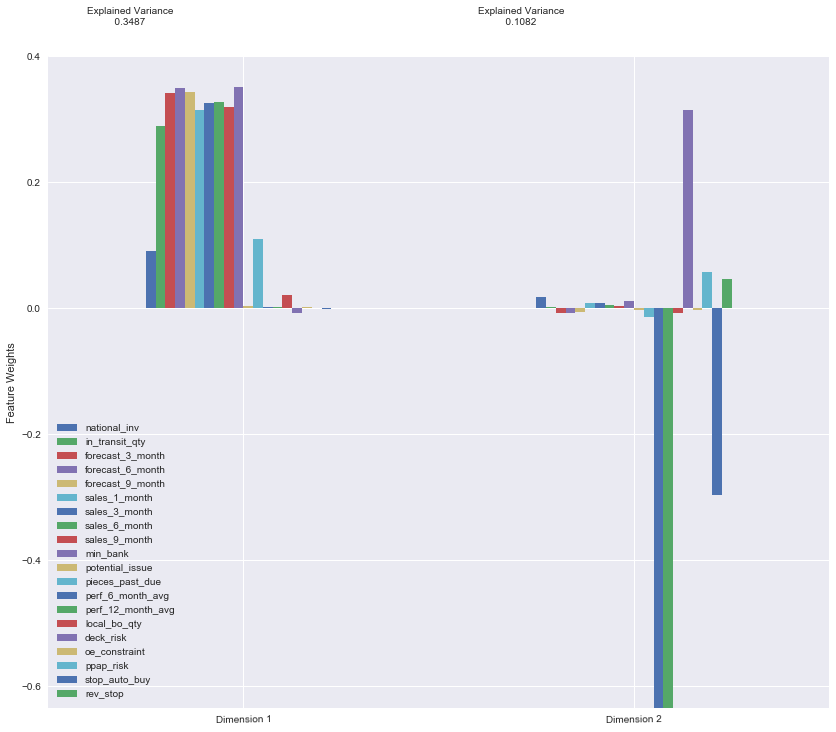

In [12]:
#pca explanation
def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,12))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=1)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca = PCA(n_components =2, random_state =42).fit(samples)
pca_result = pca_results(samples,pca)

In [55]:
pca_result['Explained Variance'].cumsum()

Dimension 1    0.3741
Dimension 2    0.4848
Name: Explained Variance, dtype: float64

In [43]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.feature_selection import SelectKBest
from imblearn.metrics import sensitivity_score
from sklearn.linear_model import LinearRegression
def fit_model(X, y):
    # This dataset is too high-dimensional. Better do PCA:
    pca = PCA(random_state = 42)

    # Maybe some original features where good too?
    selection = SelectKBest(k=1)
    
    combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])
    svm = LinearRegression(fit_intercept=False)
    #set the pipeline
    pipeline = Pipeline([("features", combined_features), ("svm", svm)])
    
    # Create cross-validation sets from the training data
    #cv_sets = ShuffleSplit(10, test_size = 0.20, random_state = 42)

    #params dictionary for grid search
    param_grid = dict(features__pca__n_components=[12],
                  features__univ_select__k=[1, 2])

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(sensitivity_score)

    # TODO: Create the grid search object
    grid = GridSearchCV(pipeline, param_grid,scoring = scoring_fnc,cv = 3)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

In [17]:
# Fit the training data to the model using grid search
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(std_data,labels, test_size =0.3, random_state =42)

In [ ]:
clf = fit_model(X_train,y_train)
print 'operation completed'
display(clf.get_params())


In [ ]:
#save estimator
pickle.dump(clf), open('estimator.p', 'wb')

In [ ]:

combined_features = FeatureUnion([("pca", pca), ("univ_select", selection)])

## loading testing data
now load the test data and test on the classifier.

In [ ]:
# Load the kepler dataset
Testdata = pd.read_csv(os.path.join("project_dataset", 'exoTest.csv'),index_col=0)
#    print "kepler dataset has {} samples with {} features each.".format(*data.shape)
#except:
#    print "Dataset could not be loaded. Is the dataset missing?"

In [ ]:
#create label array and drop it from features
testlabels = Testdata.LABEL
#labels = [1 if x == 2 else 0 for x in labels]
testlabels.replace(1,0, inplace=True)
testlabels.replace(2,1, inplace=True)
Testdata.drop('LABEL',axis=1, inplace =True)

## evaluation of the result

In [ ]:
X_test = pca.transform(Testdata)
y_pred = clf_C.predict(X_test)
print classification_report(testlabels, y_pred)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(100*cm/float(cm.sum()))
ax = sns.heatmap(df_cm.round(2), annot=True, cmap='Greys', fmt='g', linewidths=1)
ax.set_title("Confusion Matrix - per 100 predictions")
ax.set_xlabel('Predicted', fontsize=16)
ax.set_ylabel('True', fontsize=16, rotation=90)
plt.show()